<font size=10>Assignment 4

<font size=8>Introduction

<font size=4> Objective: Develop a comprehensive model of the Co-Zr-Cr-Ti quaternary system and assess its glass-forming capabilities through the utilization of Maximum Full Width at Half Maximum (MaxFWHM) measurements. The investigation will involve a thorough exploration of pertinent features, employing sophisticated featurization techniques, and implementing cross-validation methodologies to enhance the model's predictability in accordance with physical measurements.

<font size=8>Code

<font size=6>Modules

In [162]:
#Loading dependencies
import scipy.io
import numpy.matlib as nm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [163]:
#Versions used
print(pd.__version__) #1.5.3
print(np.__version__) #1.26.4
print(scipy.__version__) #1.12.0
print(sklearn.__version__) #1.2.1


1.5.3
1.26.4
1.12.0
1.2.1


<font size=6>Importing data

In [164]:
# Load data from the same CSV file with different sheets
xls_file = pd.ExcelFile('Metallic Glass Data\Metallic Glass Data.xlsx')  # Update with your actual file name

# Read data from different sheets
CrTiZr_data = xls_file.parse('CrTiZr')
CrCoZr_data = xls_file.parse('CrCoZr')
CoTiZr_data = xls_file.parse('CoTiZr')

#add a string of the elements in the compound
CrTiZr_data['comp_string'] = 'CrTiZr'
CrCoZr_data['comp_string'] = 'CrCoZr'
CoTiZr_data['comp_string'] = 'CoTiZr'

#creating an element map
element_map = {'Co': 'CrTiZr',
               'Ti': 'CrCoZr',
               'Cr': 'CoTiZr'}

In [165]:
#using function given in Practical #5 for plotting ternary diagrams

import ternary

def plot_ternary(data, components, z, label, title=''):
    
    fig, ax = plt.subplots()
    scale = 100

    grid = plt.GridSpec(10, 10, wspace=2, hspace=1)
    ax = plt.subplot(grid[:,:9])

    figure, tax = ternary.figure(scale=scale, ax=ax)
    # Draw Boundary and Gridlines
    tax.boundary(linewidth=2.0)
    tax.gridlines(color="red", multiple=10)

    # Set Axis labels and Title
    fontsize = 12
    offset = 0.14
    tax.right_corner_label(components[0], fontsize=fontsize, offset=0.2, fontweight='bold')
    tax.top_corner_label(components[2], fontsize=fontsize, offset=0.23, fontweight='bold')
    tax.left_corner_label(components[1], fontsize=fontsize, offset=0.2, fontweight='bold')
    tax.left_axis_label("at.%", fontsize=fontsize, offset=offset)
    tax.right_axis_label("at.%", fontsize=fontsize, offset=offset)
    tax.bottom_axis_label("at.%", fontsize=fontsize, offset=offset)
    tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025, clockwise= True)
    tax.get_axes().axis('off')
    tax.clear_matplotlib_ticks()

    
    
    # Create color map and plot color bar
    cmap = plt.cm.plasma
    norm = plt.Normalize(0, z.max())
    
    tax.scatter(data, marker='o', c=cmap(norm(z)), edgecolors='k', alpha=1, s=30, vmin=z.min(), vmax=z.max())
    
    ax = plt.subplot(grid[1:-1,9:])
    cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical', label=label)
    cb1.set_label(label=label, size=18)
    fig.suptitle(title,y=1,weight='bold')

Ternary system exploration

C:\Users\EVA-02\AppData\Local\Temp\ipykernel_13220\16954005.py:11: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.

c:\Users\EVA-02\AppData\Local\Programs\Python\Python310\lib\site-packages\ternary\plotting.py:148: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored

C:\Users\EVA-02\AppData\Local\Temp\ipykernel_13220\16954005.py:11: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.

c:\Users\EVA-02\AppData\Local\Programs\Python\Python310\lib\site-packages\ternary\plotting.py:148: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored

C:\Users\EVA-02\AppData\Local\Temp\ipykernel_13220\16954005.py:11: MatplotlibDeprecationWarning:

Auto-removal of overla

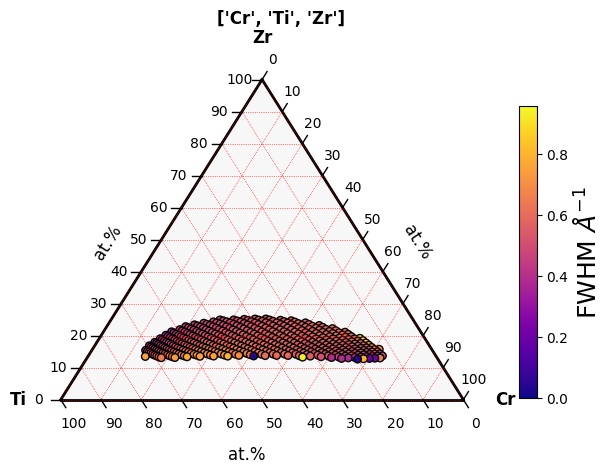

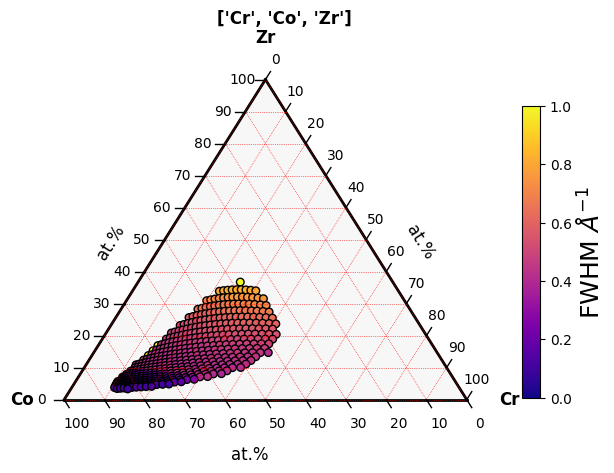

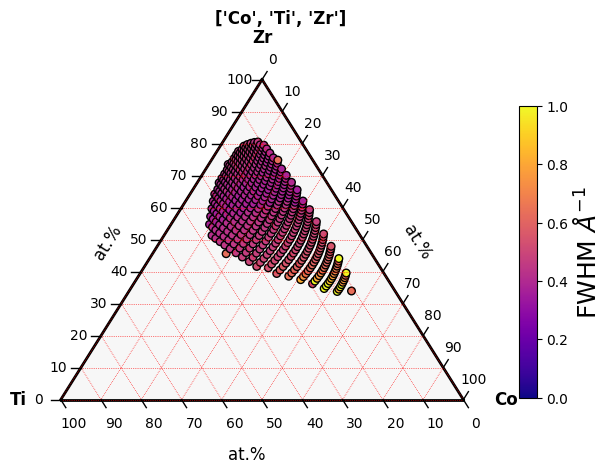

In [166]:
# Merge the ternary systems to create the quaternary system dataset

# a = cr , b = co , c =ti , d = zr
components = ['Cr','Co','Ti','Zr']
CoTiZr_components = [components[i] for i in [1,2,3]]
CrCoZr_components = [components[i] for i in [0,1,3]]
CrTiZr_components = [components[i] for i in [0,2,3]]

component_list = [CrTiZr_components,CrCoZr_components,CoTiZr_components]
data = [CrTiZr_data,CrCoZr_data,CoTiZr_data]

for c,d in zip(component_list,data):
    cmp =d.loc[:,c].to_numpy()
    cmp*=100
    points=nm.vstack((cmp[:,0].T,cmp[:,2].T)).T

    plot_ternary(points, c, d['MaxFWHM'], label='FWHM $\AA^{-1}$',title= f'{c}')

Bridge - Creating a quaternary dataframe

In [167]:
temp= pd.concat([CrTiZr_data.pop('MaxFWHM'), CrCoZr_data.pop('MaxFWHM'), CoTiZr_data.pop('MaxFWHM')],ignore_index=True)
quaternary_data = pd.merge(CrTiZr_data,CrCoZr_data,on=['Cr', 'Zr','comp_string'],how='outer')
quaternary_data = pd.merge(quaternary_data, CoTiZr_data, on=['Co', 'Ti', 'Zr','comp_string'],how='outer')
quaternary_data=pd.concat([quaternary_data,temp],axis=1)

Filling NaN values

In [168]:
#NanN values appear where element is missing, so 0 is a valid replacement
quaternary_data.fillna(0,inplace=True)

In [169]:
quaternary_data

,Cr,Ti,Zr,comp_string,Co,MaxFWHM
0,0.270945,0.480078,0.248976,CrTiZr,0.000000,0.491267
1,0.196268,0.575674,0.228059,CrTiZr,0.000000,0.427990
2,0.215384,0.550948,0.233668,CrTiZr,0.000000,0.455407
3,0.235852,0.525511,0.238637,CrTiZr,0.000000,0.470065
4,0.257642,0.499465,0.242892,CrTiZr,0.000000,0.480589
...,...,...,...,...,...,...
1318,0.000000,0.110050,0.373767,CoTiZr,0.516183,0.769533
1319,0.000000,0.104183,0.381011,CoTiZr,0.514806,0.744379
1320,0.000000,0.098608,0.388291,CoTiZr,0.513101,0.642379
1321,0.000000,0.093310,0.395614,CoTiZr,0.511076,1.000000


<font size=6>Featurize

Getting a matpygem composition value

In [170]:
#Conversion code modiffied from GPT 3.5 template
import pandas as pd
from pymatgen import core

# Apply the featurizer to each row of the DataFrame
compositions = []
for index, row in quaternary_data[components].iterrows():
    # Convert the row (elemental fractions) to a dictionary
    element_fractions = row.to_dict()
     # Convert the elemental fractions to a Pymatgen Composition object
    composition = core.Composition(element_fractions)
    # Append the features to the result list
    compositions.append(composition)
# Convert the result features list to a new DataFrame
compositions_df = pd.DataFrame(pd.Series(compositions,name='composition'))
quaternary_data_with_composition = pd.concat([quaternary_data, compositions_df],axis=1)


In [171]:
quaternary_data_with_composition

,Cr,Ti,Zr,comp_string,Co,MaxFWHM,composition
0,0.270945,0.480078,0.248976,CrTiZr,0.000000,0.491267,"(Cr, Ti, Zr)"
1,0.196268,0.575674,0.228059,CrTiZr,0.000000,0.427990,"(Cr, Ti, Zr)"
2,0.215384,0.550948,0.233668,CrTiZr,0.000000,0.455407,"(Cr, Ti, Zr)"
3,0.235852,0.525511,0.238637,CrTiZr,0.000000,0.470065,"(Cr, Ti, Zr)"
4,0.257642,0.499465,0.242892,CrTiZr,0.000000,0.480589,"(Cr, Ti, Zr)"
...,...,...,...,...,...,...,...
1318,0.000000,0.110050,0.373767,CoTiZr,0.516183,0.769533,"(Co, Ti, Zr)"
1319,0.000000,0.104183,0.381011,CoTiZr,0.514806,0.744379,"(Co, Ti, Zr)"
1320,0.000000,0.098608,0.388291,CoTiZr,0.513101,0.642379,"(Co, Ti, Zr)"
1321,0.000000,0.093310,0.395614,CoTiZr,0.511076,1.000000,"(Co, Ti, Zr)"


featurzing with magpie

In [172]:
#Template modified from lecture 5 slides

from matminer.featurizers.composition import composite as comp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)#stack overflow "https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning"

features = [ "Number", "MendeleevNumber", "AtomicWeight", "MeltingT",  "Column", "Row", "CovalentRadius", "Electronegativity", "NsValence", "NpValence", "NdValence", "NfValence", "NValence", "NsUnfilled", "NpUnfilled", "NdUnfilled", "NfUnfilled", "NUnfilled","GSvolume_pa", "GSbandgap", "GSmagmom"]
stats = ["mean", "avg_dev", "minimum", "maximum", "range"]
magpie = comp.ElementProperty('magpie', features, stats) 
features_df = pd.DataFrame()
for row in range(len(quaternary_data_with_composition)):
    feature = magpie.featurize(quaternary_data_with_composition['composition'][row])
    features_df = features_df.append(pd.Series(feature),ignore_index=True)
quaternary_data_featurized = pd.concat([quaternary_data_with_composition,features_df],axis=1)
    
    


In [173]:
quaternary_data_featurized.head()

,Cr,Ti,Zr,comp_string,Co,MaxFWHM,composition,0,1,2,...,95,96,97,98,99,100,101,102,103,104
0,0.270945,0.480078,0.248976,CrTiZr,0.0,0.491267,"(Cr, Ti, Zr)",27.023466,6.461701,22.0,...,0.0,0.0,0.0,0.0,0.0,0.000011,0.000011,0.0,0.000023,0.000023
1,0.196268,0.575674,0.228059,CrTiZr,0.0,0.427990,"(Cr, Ti, Zr)",26.497591,6.158682,22.0,...,0.0,0.0,0.0,0.0,0.0,0.000013,0.000011,0.0,0.000023,0.000023
2,0.215384,0.550948,0.233668,CrTiZr,0.0,0.455407,"(Cr, Ti, Zr)",26.636795,6.245111,22.0,...,0.0,0.0,0.0,0.0,0.0,0.000012,0.000011,0.0,0.000023,0.000023
3,0.235852,0.525511,0.238637,CrTiZr,0.0,0.470065,"(Cr, Ti, Zr)",26.767161,6.315677,22.0,...,0.0,0.0,0.0,0.0,0.0,0.000012,0.000011,0.0,0.000023,0.000023
4,0.257642,0.499465,0.242892,CrTiZr,0.0,0.480589,"(Cr, Ti, Zr)",26.887347,6.369926,22.0,...,0.0,0.0,0.0,0.0,0.0,0.000011,0.000011,0.0,0.000023,0.000023


<font size=6>CV

Loco

Creating a test and train split of the featurized data set

In [174]:
#creating a index map of where certain compositions are found
elements = ['Cr',#will represent 'CoTiZr'
            'Co',#will represent 'CrTiZr'
            'Ti']#will represent 'CrCoZr'
#creating a matrix
id_acta={}
for i in elements:
    id_acta[i] = quaternary_data_featurized[i] == 0
#id__acta identifies where there are no values for a certain element. ie represents the ternary missing that element

In [175]:
comp_strings = pd.DataFrame(quaternary_data.pop('comp_string'),columns=['comp_string'])

In [176]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import StandardScaler

#intiate model
model=LinearRegression()
scaler=StandardScaler(with_mean=True,with_std=True)
column_labels = quaternary_data.columns.tolist()
quaternary_data_scaled = scaler.fit_transform(quaternary_data)
quaternary_data_scaled = pd.DataFrame(quaternary_data_scaled,columns=column_labels)
target_values = pd.DataFrame(quaternary_data_scaled.pop('MaxFWHM'),columns=['MaxFWHM'])
results = {}


#loco cv loop for each ternary
for element in elements:
    #fit model
    model.fit(quaternary_data_scaled[~id_acta[element]],target_values[~id_acta[element]])

    # Predict the target variable for the test set
    y_pred = model.predict(quaternary_data_scaled[id_acta[element]])
    y_observed=model.predict(quaternary_data_scaled[~id_acta[element]])
    # Evaluate the model performance (you can choose other metrics)
    r_squared_pred = r2_score(target_values[id_acta[element]],y_pred)
    r_squared_observed = r2_score(target_values[~id_acta[element]],y_observed)
    mse = mean_squared_error(target_values[id_acta[element]], y_pred)
    print(f'the predicted r2 value of sans {element} : {r_squared_pred}')
    print(f'the observed r2 value of sans {element} : {r_squared_observed}')   
    print(f'the mse value of sans {element} : {mse}')
    results[element] =(r_squared_pred,r_squared_observed,mse)
    

the predicted r2 value of sans Cr : -36.22945726935945
the observed r2 value of sans Cr : 0.6533926213520282
the mse value of sans Cr : 21.740356191213543
the predicted r2 value of sans Co : -1.09775371468655
the observed r2 value of sans Co : 0.15298366087787918
the mse value of sans Co : 0.7345120404194585
the predicted r2 value of sans Ti : -4.611784274233048
the observed r2 value of sans Ti : 0.43710120319683254
the mse value of sans Ti : 9.184924869866993


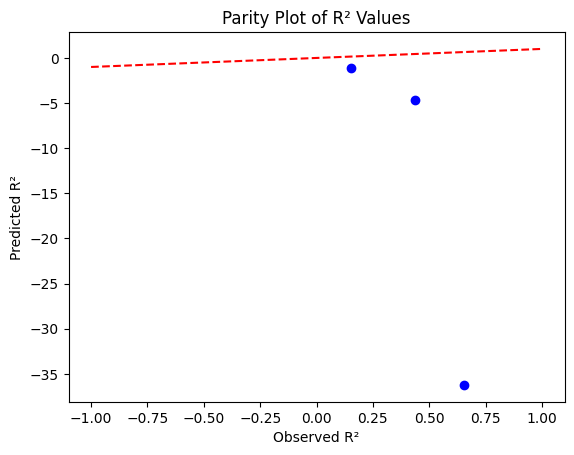

In [177]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Parity plot
plt.scatter([x[1] for x in list(results.values())],[y[0] for y in list(results.values())], color='blue')
plt.plot([-1,1], [-1,1], linestyle='--', color='red')
#plt.plot([min(r2_obeserved), max(r2_obeserved)], [min(r2_obeserved), max(r2_obeserved)], linestyle='--', color='red')
plt.xlabel('Observed R²')
plt.ylabel('Predicted R²')
plt.title('Parity Plot of R² Values')
plt.show()

random

In [178]:
from sklearn.model_selection import StratifiedShuffleSplit#function addapted from Lecture 5 slides

def proportional_split(df, test_size=0.20, verbose=True):
    cv = StratifiedShuffleSplit(n_splits=1, test_size=test_size,random_state=0)
    for train, test in cv.split(df,df['comp_string']):
        if verbose:
            print(f"Training data points: {len(train)}")
            print(f"Test data points: {len(test)}")
            print(f"total points:{len(train)+len(test)}")
    return train,test

In [179]:
#quaternary_data = pd.concat([quaternary_data,comp_strings],axis=1)

In [180]:
quaternary_data.pop('MaxFWHM')

0       0.491267
1       0.427990
2       0.455407
3       0.470065
4       0.480589
          ...   
1318    0.769533
1319    0.744379
1320    0.642379
1321    1.000000
1322    0.634856
Name: MaxFWHM, Length: 1323, dtype: float64

In [181]:
from sklearn.model_selection import cross_validate,cross_val_score,cross_val_predict


X_train, X_test, y_train, y_test = train_test_split(quaternary_data, target_values, test_size=0.2, random_state=0)
r2_obeserved =[]
cv_res = cross_validate(model, X_train, y_train, cv=5,return_estimator=True,scoring='r2')
for estimator in cv_res['estimator']:
    y_pred = estimator.predict(X_test)
    r2 = r2_score(y_test,y_pred)
    r2_obeserved.append(r2)


In [182]:
r2_predicted = cv_res['test_score']

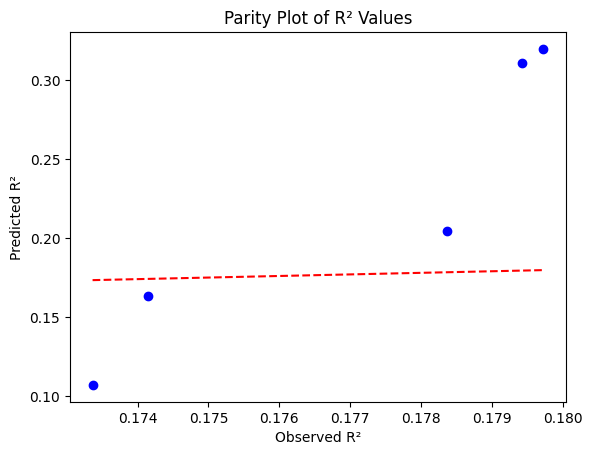

In [183]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Parity plot
plt.scatter(r2_obeserved,r2_predicted,color='blue')
plt.plot([min(r2_obeserved),max(r2_obeserved)], [min(r2_obeserved),max(r2_obeserved)], linestyle='--', color='red')
#plt.plot([min(r2_obeserved), max(r2_obeserved)], [min(r2_obeserved), max(r2_obeserved)], linestyle='--', color='red')
plt.xlabel('Observed R²')
plt.ylabel('Predicted R²')
plt.title('Parity Plot of R² Values')
plt.show()

In [184]:
cv_res

{'fit_time': array([0.01201177, 0.01149106, 0.01150131, 0.02599168, 0.01848745]),
 'score_time': array([0.00749302, 0.00950408, 0.00900173, 0.01101041, 0.01550436]),
 'estimator': [LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression()],
 'test_score': array([0.10693216, 0.31994812, 0.16309894, 0.31080666, 0.20448967])}

In [185]:
cv_res_best_index = list(cv_res['test_score']).index(max(list(cv_res['test_score'])))

In [186]:
best_model = cv_res['estimator'][cv_res_best_index]
print(f'The best mode contains intercept: {best_model.intercept_} and the line coefficients as : {best_model.coef_}')
y_prediction = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_prediction)
r2=r2_score(y_test, y_prediction)
print(f'The MSE value is {mse} and the R2 score is {r2}')

The best mode contains intercept: [16295406.44802633] and the line coefficients as : [[-16295405.3368421  -16295406.45949757 -16295406.11658242
  -16295407.69698797]]
The MSE value is 0.8973599860893605 and the R2 score is 0.17972223253958797


In [187]:
sample=np.array(X_test.iloc[100])

In [188]:
sample = sample.reshape(1, -1)

In [189]:
result = best_model.predict(sample)

c:\Users\EVA-02\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:420: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



In [190]:
result[0][0]

-0.02287820540368557

In [191]:
for idx, model in enumerate(cv_res['estimator']):
    coefficients = model.coef_
    intercept = model.intercept_
    print(f'Fold {idx + 1} - Coefficients: {coefficients}, Intercept: {intercept}')

Fold 1 - Coefficients: [[43986470.1245729  43986468.87936978 43986469.17927872 43986467.57528433]], Intercept: [-43986468.90431926]
Fold 2 - Coefficients: [[-16295405.3368421  -16295406.45949757 -16295406.11658242
  -16295407.69698797]], Intercept: [16295406.44802633]
Fold 3 - Coefficients: [[37589946.67341264 37589945.37307049 37589945.75552545 37589944.12543111]], Intercept: [-37589945.45620295]
Fold 4 - Coefficients: [[-23655692.56810004 -23655693.6198835  -23655693.30322856
  -23655694.80782737]], Intercept: [23655693.61851085]
Fold 5 - Coefficients: [[53834004.19810719 53834002.86903186 53834003.28781909 53834001.67952829]], Intercept: [-53834002.95341142]


train

temp

predict

evaluate

In [207]:
x = 0.75

def shannon_entropy(p):
    global x
    p = [i*(1-x) for i in p]
    p.append(x)

    p=np.array(p)
    p=p.reshape(1, -1)
    y=best_model.predict(p)
    return y[0][0]

c:\Users\EVA-02\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:420: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

c:\Users\EVA-02\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:420: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

c:\Users\EVA-02\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:420: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

c:\Users\EVA-02\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:420: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

c:\Users\EVA-02\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:420: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

c:\Users\E

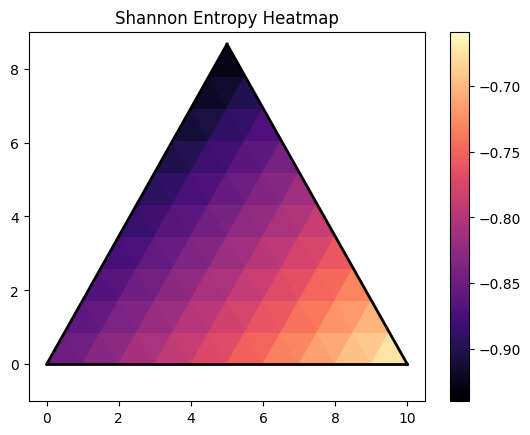

In [210]:
import ternary
scale = 10

figure, tax = ternary.figure(scale=scale)
tax.heatmapf(shannon_entropy, boundary=True, style="triangular",cmap='magma')
tax.boundary(linewidth=2.0)
tax.set_title("Shannon Entropy Heatmap")

tax.show()